# Playground Zollman-effect



# Setup

In [103]:
# Hello Max!

import numpy as np
from agents_clean import Agent
from model_clean import Model
from hybrid_networks_clean import rewire_network, randomize_network_v2, create_hybrid_network
from tqdm import tqdm
import networkx as nx
import pandas as pd
import random

%load_ext autoreload
%autoreload 2                     

import opinionated
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")
import colormaps as cmaps  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# First Test (1 simulation)


In [104]:
n_agents = 100
my_network = nx.complete_graph(n_agents) #create_hybrid_network(20,degree=5,p_preferential_attachment=.01)#nx.erdos_renyi_graph(n_agents, 0.009)
my_model = Model(my_network, n_experiments=10, uncertainty=0.001,agent_type = "beta")
my_model.run_simulation(number_of_steps=100,show_bar=True) #number_of_steps is a max amount


  0%|          | 0/100 [00:00<?, ?it/s]

In [106]:
my_model.n_steps

10

100
Notice that this will have length len(steps_runned)


<Axes: title={'left': 'Mean Credences'}>

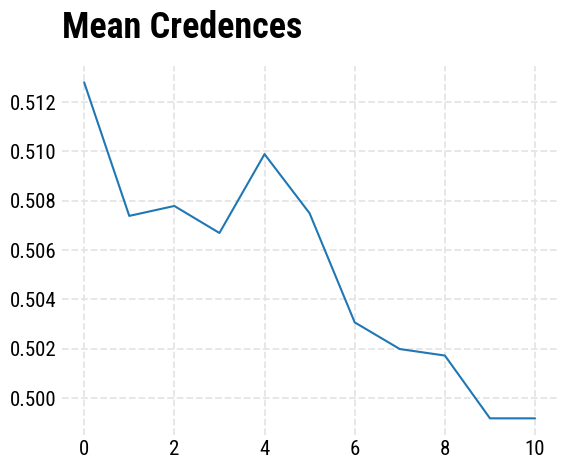

In [107]:
df = pd.DataFrame(my_model.agent_histories)
print(len(df))
mean_credences = df.mean()
print('Notice that this will have length len(steps_runned)')
mean_credences.plot(title='Mean Credences')

Notice that this will have length len(steps_runned)-1


<Axes: title={'left': 'Mean Choices of Population (1=correct, 0=wrong)'}>

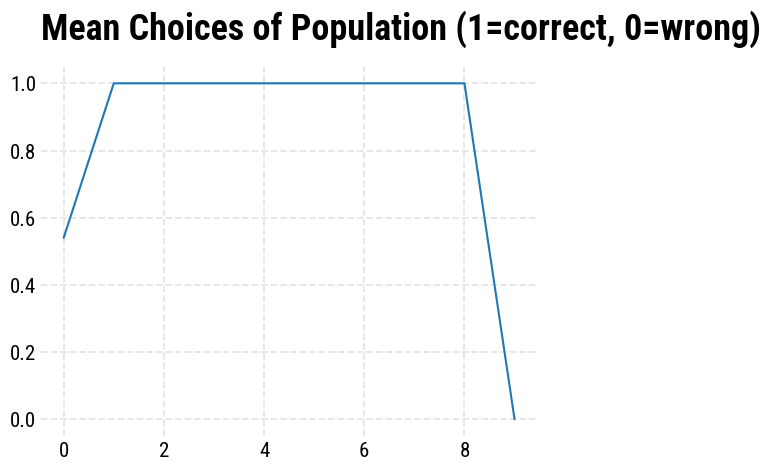

In [108]:
df = pd.DataFrame(my_model.agents_choices)
mean_choices = df.mean()
print('Notice that this will have length len(steps_runned)-1')
mean_choices.plot(title='Mean Choices of Population (1=correct, 0=wrong)')


Notice that this will have length len(steps_runned)
This is the history of credences for each agent


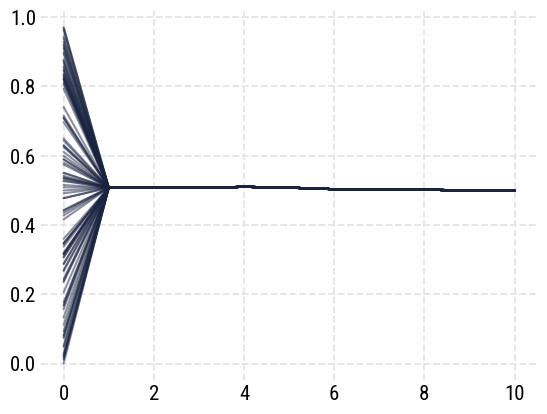

In [109]:
print('Notice that this will have length len(steps_runned)')
print('This is the history of credences for each agent')
for agent_hist in my_model.agent_histories:
    plt.plot(agent_hist,c="#1a2340",alpha=.5)

# Simulations with simple networks

(Here we replicate the wheel, cycle, complete setup)

## First we define the simulation function and run it

In [110]:
def create_graph(keyword, n_agents):
    if keyword == "complete":
        return nx.complete_graph(n_agents)
    elif keyword == "wheel":
        return nx.wheel_graph(n_agents)
    elif keyword == "cycle":
        return nx.cycle_graph(n_agents)
    else:
        raise ValueError("Invalid keyword. Please choose 'complete', 'wheel', or 'cycle'.")

def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 20)
        network_keyword = random.choice(["complete", "wheel", "cycle"])
        network = create_graph(network_keyword, n_agents)
        uncertainty = 0.01
        n_experiments = random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "network_type" : network_keyword,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
# parameter_dictionaries = generate_parameters(50)


In [111]:
import numbers
def run_simulation_with_params(param_dict, number_of_steps=1000, show_bar=False,agent_type="beta"):
    # Extract the network directly since it's already a NetworkX graph object
    my_network = param_dict['network']
    # Other parameters are directly extracted from the dictionary
    my_model = Model(my_network, n_experiments=param_dict['n_experiments'], uncertainty=param_dict['uncertainty']
                    , agent_type=agent_type)
    # Run the simulation with predefined steps and show_bar option
    
    my_model.run_simulation(number_of_steps=number_of_steps, show_bar=show_bar)
  
    

    result_dict = {
        key: value 
        for key, value in param_dict.items() 
        if isinstance(value, (numbers.Number, str, tuple, list))}   
    result_dict['true_consensus'] = my_model.conclusion
    result_dict['true_consensus_alternative_stop'] = my_model.conclusion_alternative_stop
    df = pd.DataFrame(my_model.agents_choices) 
    result_dict['choice_consensus'] = df.mean()[len(df.mean())-1]
    result_dict['convergence_step'] = my_model.n_steps # takes note of the last reported step
    result_dict['agent_type']=agent_type
    
    return result_dict


parameter_dictionaries = generate_parameters(1000)  # Generate one for demonstration
result = run_simulation_with_params(parameter_dictionaries[1], number_of_steps=10000, show_bar=False)
print(result['choice_consensus'])
print(result['convergence_step'])


1.0
415


In [112]:
# Ensure your run_simulation_with_params function and others are defined

def run_simulations(param_list, number_of_steps=1000, show_bar=False,agent_type="beta"):
    def run_simulation(param_dict):
        return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, show_bar=show_bar,agent_type=agent_type)
    
    results = []
    # Iterate over each parameter dictionary in the list
    for params in tqdm(param_list, desc="Running simulations"):
        result = run_simulation(params)
        results.append(result)
    
    # Convert the list of results into a Pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
parameter_dictionaries = generate_parameters(100)  # Generate parameter dictionaries
results_df = run_simulations(parameter_dictionaries, number_of_steps=1000, show_bar=False)
print(results_df)


Running simulations: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]

    n_agents network_type  uncertainty  n_experiments  true_consensus  \
0         15     complete         0.01            684             1.0   
1         12        wheel         0.01            551             1.0   
2         11        cycle         0.01            352             0.0   
3         18     complete         0.01            512             1.0   
4          3        wheel         0.01            698             0.0   
..       ...          ...          ...            ...             ...   
95        11        wheel         0.01            354             1.0   
96        11     complete         0.01            477             0.0   
97        14     complete         0.01            544             1.0   
98         3        cycle         0.01            155             0.0   
99        17     complete         0.01            733             1.0   

   true_consensus_alternative_stop  choice_consensus  convergence_step  \
0                              1.0               

In [113]:
# The difference between true consensus and choice consensus is that it happens to be the case that for the parameters explored
# if there is no true consensus at the end, then i think they should have different values
# maybe Im wrong

results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_agents                         100 non-null    int64  
 1   network_type                     100 non-null    object 
 2   uncertainty                      100 non-null    float64
 3   n_experiments                    100 non-null    int64  
 4   true_consensus                   100 non-null    float64
 5   true_consensus_alternative_stop  100 non-null    object 
 6   choice_consensus                 100 non-null    float64
 7   convergence_step                 100 non-null    int64  
 8   agent_type                       100 non-null    object 
dtypes: float64(3), int64(3), object(3)
memory usage: 7.2+ KB


## Now Some Standard Plotting

In [114]:
def plot_big_results(results_df=results_df,variable_of_interest = 'true_consensus'):
    grouped = results_df.groupby(['network_type', 'n_agents'])[variable_of_interest].mean().reset_index()

    # Preparing for the line plot
    #grouped['mid_bin'] = grouped['binned'].apply(lambda x: x.mid).astype(float)  # Getting the midpoint of bins for plotting

    # Plotting
    plt.figure(figsize=(12, 8))

    for network_type in results_df['network_type'].unique():
        subset = grouped[grouped['network_type'] == network_type]
        plt.plot(subset['n_agents'], subset[variable_of_interest], marker='o', label=network_type)

    plt.xlabel('Number of Agents')
    plt.ylabel('Share of '+variable_of_interest)
    plt.title('Share of '+ variable_of_interest +' by Number of Agents and Network Type')
    opinionated.add_legend(title='Network Type')

    plt.grid(True)
    plt.show()

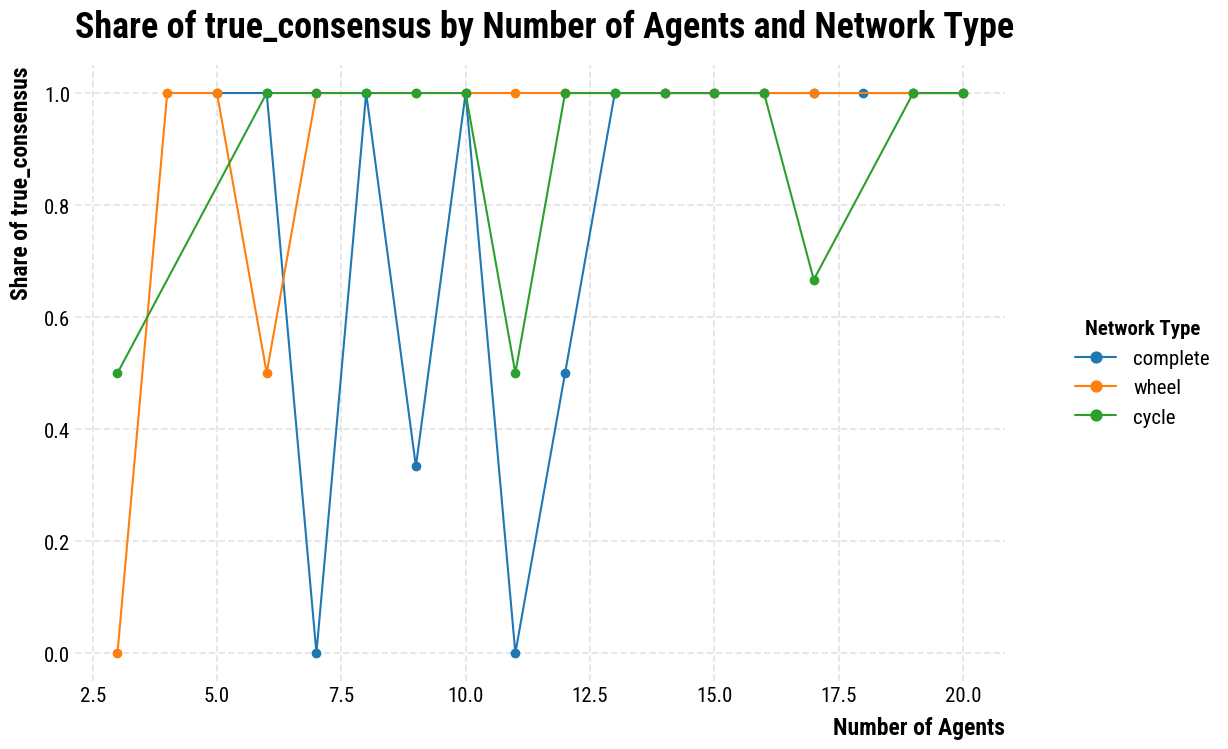

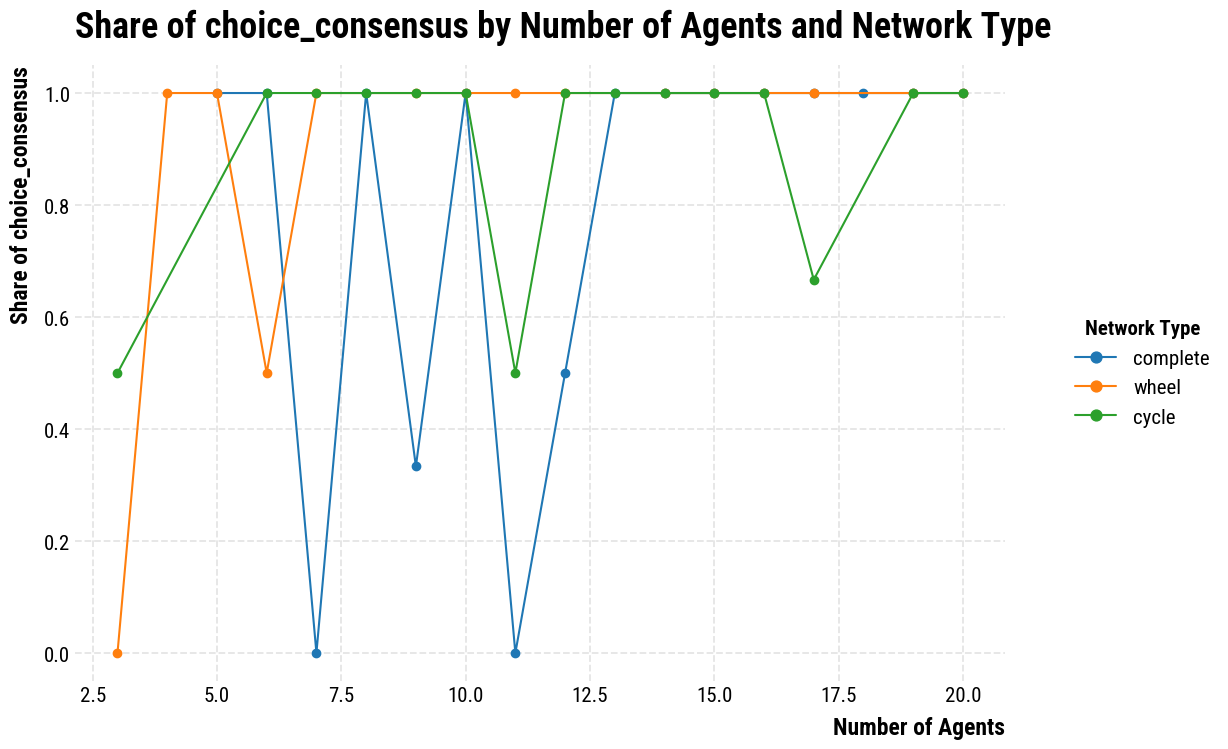

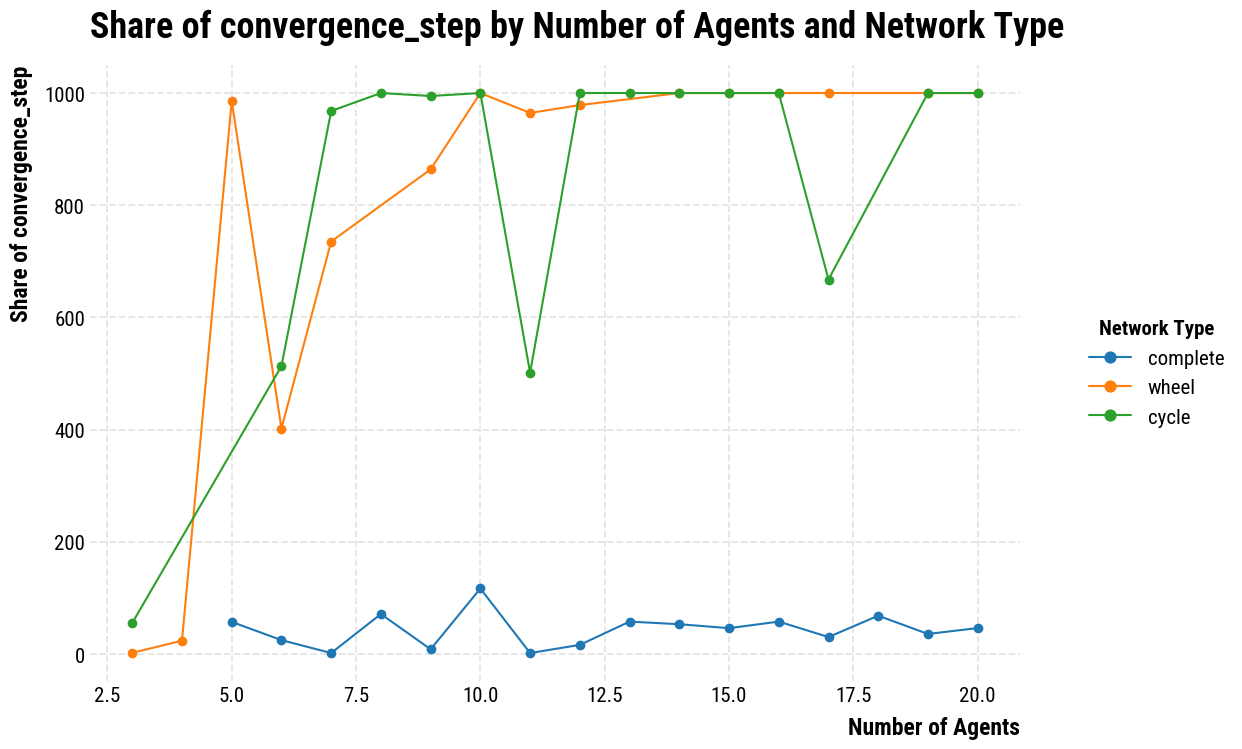

In [115]:
plot_big_results(variable_of_interest = 'true_consensus')
plot_big_results(variable_of_interest = 'choice_consensus')
plot_big_results(variable_of_interest = 'convergence_step')

## Now some cool regression type of plotting

In [116]:
import pandas as pd
from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split


def do_regression(results_df=results_df,variable_of_interest = 'true_consensus'):
    # Splitting the DataFrame by network type
    network_types = results_df['network_type'].unique()

    my_gams = {}

    for network_type in network_types:
        # Subset the DataFrame by network type
        subset = results_df[results_df['network_type'] == network_type]
        
        # Preparing the data
        X = subset[['n_agents']]
        y = subset[variable_of_interest]#.astype(int)  # Convert boolean to integer
        
        # Splitting the data into training and testing sets for model validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Fitting the Logistic GAM model
        gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
        
        # Storing the model
        my_gams[network_type] = gam
        
        # Optionally, you can print out model accuracy or other statistics here
        print(f"Model for {network_type}:")
        print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
        print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
        print("-" * 30)
        
    return my_gams

def plot_regression(results_df=results_df,variable_of_interest = 'true_consensus'):
    my_gams = do_regression(results_df=results_df,variable_of_interest = variable_of_interest)
    # Set the size of the figure
    plt.figure(figsize=(10, 6))

    cmap= cmaps.colorblind_10

    X_range = np.linspace(X['n_agents'].min(), X['n_agents'].max(), 100)

    colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]

    for i, (network_type, gam) in enumerate(my_gams.items()):
        conf = gam.confidence_intervals(X_range.reshape(-1, 1), width=0.95, quantiles=None)
        plt.fill_between(X_range, conf[:, 0], conf[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)


    for i, (network_type, gam) in enumerate(my_gams.items()):
        # Generating a range of values for n_agents to predict and plot
        # Predicting with the model
        #y_pred, conf = pdep, confi = model.partial_dependence(term=0, width=.95)
        y_pred = gam.predict_proba(X_range.reshape(-1, 1))

        # Plotting predicted probabilities
        plt.plot(X_range, y_pred,c=colors[i], label=f'{network_type}')
        
    # Adding title, labels, and legend
    plt.title('Effect of n_agents on '+ variable_of_interest +' Probability')
    plt.xlabel('Number of Agents')
    plt.ylabel('Probability of ' +variable_of_interest)
    plt.legend()
    plt.show()

Model for complete:
Accuracy on training data: 0.8
Accuracy on test data: 0.8888888888888888
------------------------------
Model for wheel:
Accuracy on training data: 0.88
Accuracy on test data: 0.9090909090909091
------------------------------
Model for cycle:
Accuracy on training data: 0.875
Accuracy on test data: 1.0
------------------------------


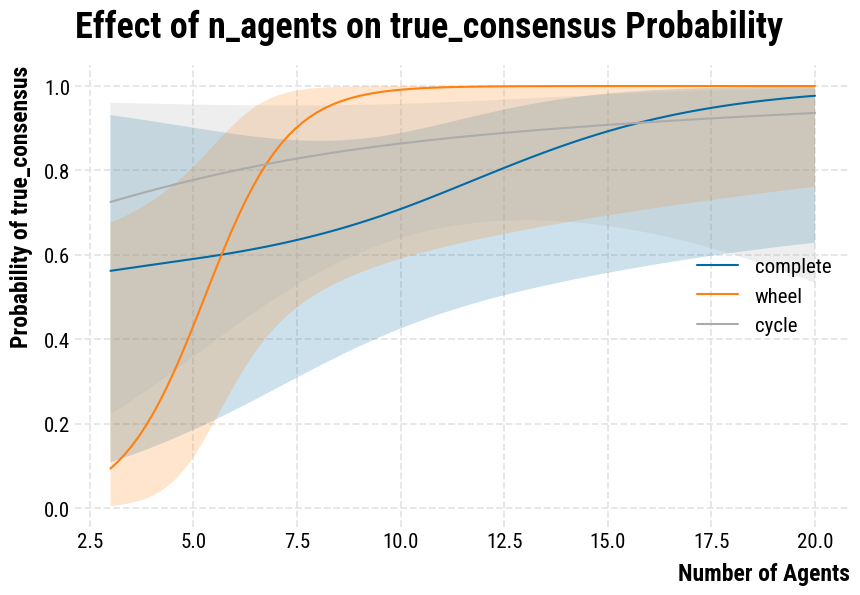

Model for complete:
Accuracy on training data: 0.8
Accuracy on test data: 0.8888888888888888
------------------------------
Model for wheel:
Accuracy on training data: 0.88
Accuracy on test data: 0.9090909090909091
------------------------------
Model for cycle:
Accuracy on training data: 0.875
Accuracy on test data: 1.0
------------------------------


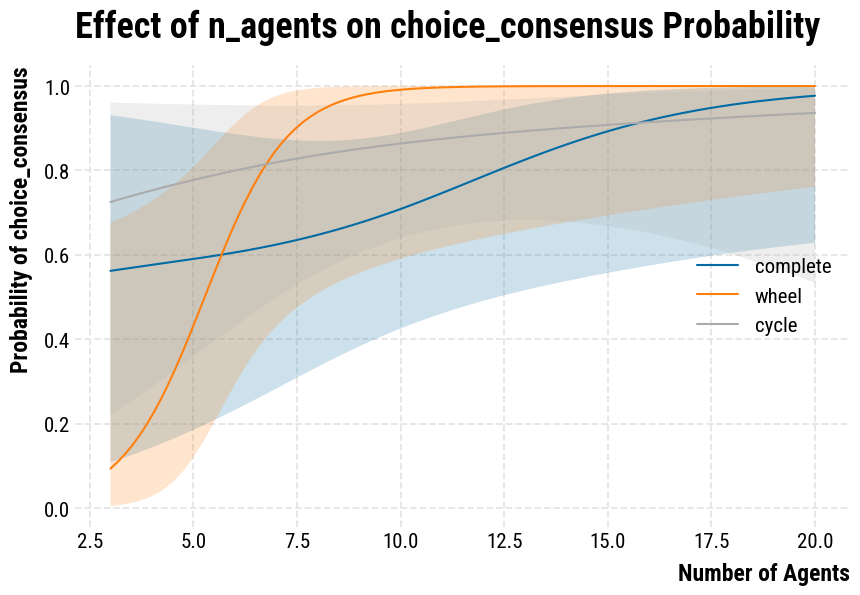

ValueError: y data is not in domain of logit link function. Expected domain: [0.0, 1.0], but found [2.0, 185.0]

In [117]:
plot_regression(results_df=results_df,variable_of_interest = 'true_consensus')
plot_regression(results_df=results_df,variable_of_interest = 'choice_consensus')
plot_regression(results_df=results_df,variable_of_interest = 'convergence_step')

# Tunable networks

## Setup working code and run simulations

In [128]:
def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 15)
        degree = random.randint(1, n_agents-1)
        p_preferential_attachment = random.uniform(0, 1)
        network = create_hybrid_network(n_agents, degree=degree, p_preferential_attachment=p_preferential_attachment)
        uncertainty = 0.001
        n_experiments = random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "degree": degree,
            "p_preferential_attachment": p_preferential_attachment,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
parameter_dictionaries = generate_parameters(50)


In [129]:
parameter_dictionaries = generate_parameters(100)  # Generate parameter dictionaries
results_df = run_simulations(parameter_dictionaries, number_of_steps=100000, show_bar=False,agent_type='beta')
print(results_df)


Running simulations: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]

    n_agents  degree  p_preferential_attachment  uncertainty  n_experiments  \
0          6       3                   0.487564        0.001            260   
1         15       9                   0.821778        0.001            856   
2         14       3                   0.306304        0.001              9   
3          9       6                   0.009388        0.001            608   
4          6       3                   0.137385        0.001            117   
..       ...     ...                        ...          ...            ...   
95        11      10                   0.102618        0.001             71   
96         6       5                   0.587054        0.001            978   
97         6       5                   0.635966        0.001            833   
98        12       5                   0.683511        0.001            708   
99        10       7                   0.283404        0.001            842   

    true_consensus  true_consensus_alternative_stop

## Plotting

In [130]:
def plot_full(results_df=results_df,variable_of_interest = 'true_consensus'): #this also does the regression
    # Preparing the data for true consensus
    X = results_df[['n_agents', 'degree', 'p_preferential_attachment']]
    y = results_df[variable_of_interest].astype(int)  # Convert boolean to integer

    # Splitting the data into training and testing sets for model validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fitting the Logistic GAM model
    gam = LogisticGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) ).fit(X_train, y_train)

    print(f"Model for {network_type}:")
    print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
    print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
    print(gam.summary())

    # Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
    # First, determine the number of plots (ignoring the intercept)
    plot_count = sum(not term.isintercept for term in gam.terms)

    # Start the figure
    plt.figure(figsize=(15, 5))  # Adjust the size as needed

    current_plot = 1
    # Initialize a list to store y-limits
    y_limits = []
    labels =['N-Agents', 'Degree', 'Prb. Preferential Attachment']
    # First pass: compute the y-axis limits for all plots
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue

        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
        y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

    # Global y limits
    global_y_min = min(limit[0] for limit in y_limits)
    global_y_max = max(limit[1] for limit in y_limits)

    # Second pass: plot with standardized y limits
    current_plot = 1
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue

        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

        # Set the subplot position
        plt.subplot(1, plot_count, current_plot)
        plt.plot(XX[:, term.feature], pdep,c=colors[i])
        plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
        
        plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

        plt.ylim(global_y_min, global_y_max)  # Set global y limits
        plt.title(labels[i]+' on '+variable_of_interest)
        plt.xlabel('')  # Remove x-axis label
        plt.ylabel('')  # Remove y-axis label


        current_plot += 1  # Move to the next plot position

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show() 



Model for cycle:
Accuracy on training data: 0.7428571428571429
Accuracy on test data: 0.7666666666666667
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       5.643
Link Function:                        LogitLink Log Likelihood:                                   -36.0375
Number of Samples:                           70 AIC:                                               83.3609
                                                AICc:                                              84.9894
                                                UBRE:                                               3.2554
                                                Scale:                                                 1.0
                                       

/var/folders/f5/dc26gyt54fs5nkjnk09tb5rw0000gp/T/ipykernel_43525/402219434.py:15: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


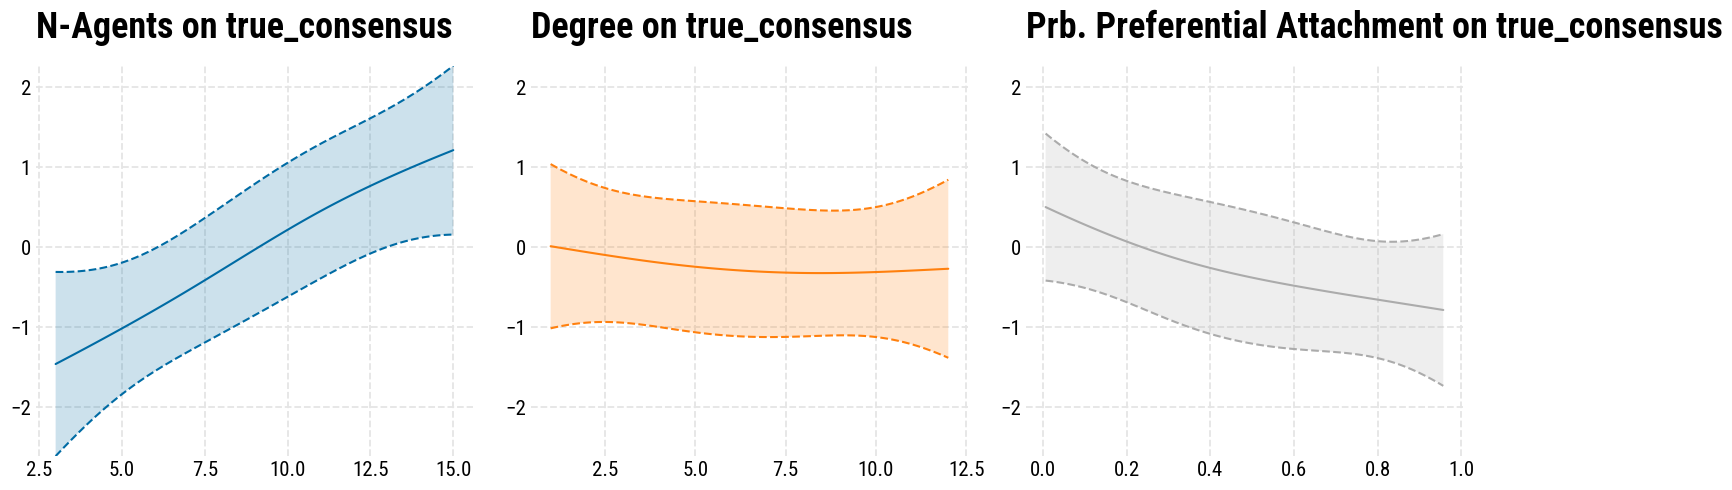

Model for cycle:
Accuracy on training data: 0.7428571428571429
Accuracy on test data: 0.7666666666666667
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       5.643
Link Function:                        LogitLink Log Likelihood:                                   -36.0375
Number of Samples:                           70 AIC:                                               83.3609
                                                AICc:                                              84.9894
                                                UBRE:                                               3.2554
                                                Scale:                                                 1.0
                                       

/var/folders/f5/dc26gyt54fs5nkjnk09tb5rw0000gp/T/ipykernel_43525/402219434.py:15: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


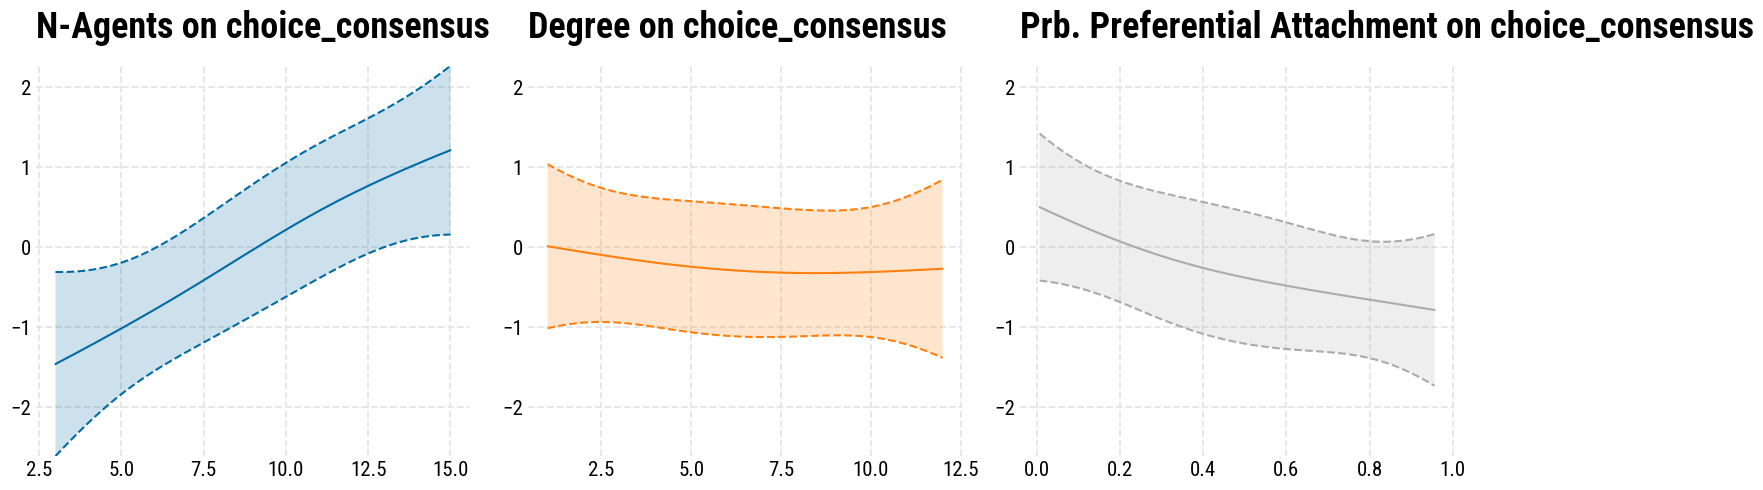

ValueError: y data is not in domain of logit link function. Expected domain: [0.0, 1.0], but found [2.0, 2387.0]

In [131]:
plot_full(results_df=results_df,variable_of_interest = 'true_consensus')
plot_full(results_df=results_df,variable_of_interest = 'choice_consensus')
plot_full(results_df=results_df,variable_of_interest = 'convergence_step')

Model for complete:
Accuracy on training data: 0.7285714285714285
Accuracy on test data: 0.6
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      5.8788
Link Function:                        LogitLink Log Likelihood:                                    -38.594
Number of Samples:                           70 AIC:                                               88.9455
                                                AICc:                                              90.6904
                                                UBRE:                                               3.3378
                                                Scale:                                                 1.0
                                                Pse

/var/folders/f5/dc26gyt54fs5nkjnk09tb5rw0000gp/T/ipykernel_35324/3144867595.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


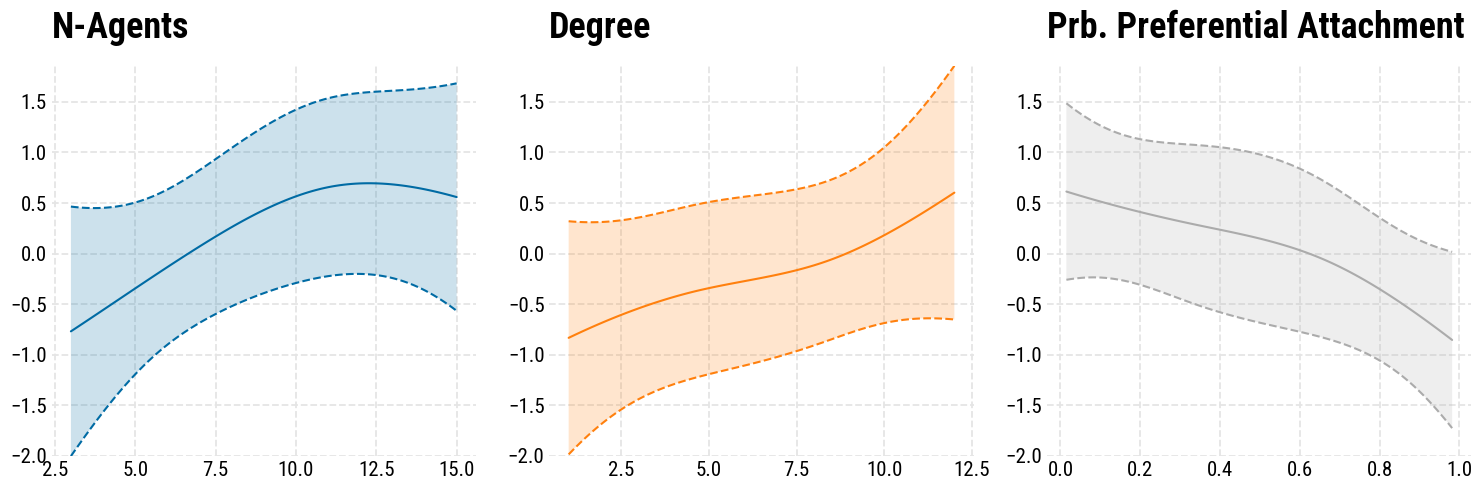

In [ ]:
# Preparing the data for true consensus
X = results_df[['n_agents', 'degree', 'p_preferential_attachment']]
y = results_df['choice_consensus'].astype(int)  # Convert boolean to integer

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LogisticGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) ).fit(X_train, y_train)

print(f"Model for {network_type}:")
print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
plt.figure(figsize=(15, 5))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels =['N-Agents', 'Degree', 'Prb. Preferential Attachment']
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    plt.title(labels[i])
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel('')  # Remove y-axis label


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()